# Bottleneck

Rapprochement des données du site web et de l'ERP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ignorer les userwarning
import warnings
warnings.simplefilter("ignore")

# Paramètres généraux des graphiques
sns.set_theme(style="white", palette='Set2')
plt.rc('axes', titlesize=14, titleweight='bold')
plt.rc('figure', autolayout=True, figsize=(7,5))

## Nettoyage des tables

In [2]:
### On commence par récupérer les données du site web
web = pd.read_excel('./data/web.xlsx')
web.head()

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,...,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,...,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,...,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,...,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,...,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [3]:
# On vérifie la taille des données
web.shape

(1513, 28)

In [4]:
# On regarde les types des données
web.dtypes

sku                              object
virtual                           int64
downloadable                      int64
rating_count                      int64
average_rating                  float64
total_sales                     float64
tax_status                       object
tax_class                       float64
post_author                     float64
post_date                datetime64[ns]
post_date_gmt            datetime64[ns]
post_content                    float64
post_title                       object
post_excerpt                     object
post_status                      object
comment_status                   object
ping_status                      object
post_password                   float64
post_name                        object
post_modified            datetime64[ns]
post_modified_gmt        datetime64[ns]
post_content_filtered           float64
post_parent                     float64
guid                             object
menu_order                      float64


In [5]:
# Rien d'anormal à priori, on va donc chercher une clé primaire pour pouvoir joindre les autres tables par la suite. 
# Le SKU, qui est un identifiant logistique devrait être une donnée remplissant ce rôle.
# Un résumé des variables 'objet' devrait nous permettre de voir s'il y a des doublons
web.describe(include='O')

,sku,tax_status,post_title,post_excerpt,post_status,comment_status,ping_status,post_name,guid,post_type,post_mime_type
count,1428,716,1430,716,1430,1430,1430,1430,1430,1430,714
unique,714,1,713,679,1,1,1,716,1430,2,1
top,bon-cadeau-25-euros,taxable,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,Les eaux de vie naissent d'une subtile alchimi...,publish,closed,closed,bon-cadeau-de-25-euros,https://www.bottle-neck.fr/?post_type=product&...,product,image/jpeg
freq,2,716,4,12,1430,1430,1430,2,1,716,714


In [6]:
# Tous les SKU sont en doublon, vérifions quels sont les deux modalités qui existent pour post_type
web['post_type'].unique()

array(['product', nan, 'attachment'], dtype=object)

In [7]:
# Chaque produit est présent deux fois dans la base:
# - une fois pour la publication du produit en lui-même,
# - une deuxième fois pour joindre l'image.
# On garde uniquement les posts de produits
web = web.loc[web['post_type'] == 'product', :]

# Il y a également des lignes sans SKU, voyons s'il y a tout de même des infos utiles
web.loc[(web['sku'].isnull()) & (web['post_title'].notnull()), :]

,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,...,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
470,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-07-31 12:07:23,...,pierre-jean-villa-cote-rotie-fongeant-2017,2019-11-02 13:24:15,2019-11-02 12:24:15,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
471,NaN,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-08-08 11:23:43,...,pierre-jean-villa-condrieu-suspendu-2018,2019-11-02 13:24:01,2019-11-02 12:24:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


In [8]:
# Ces deux lignes semblent être de vrais produits, il serait intéressant de regarder pourquoi nous n'avons pas les SKU
# Pour la suite de l'analyse, il ne sera pas possible de les rapprocher des autres tables, on ne garde donc pas les lignes sans SKU
web = web.loc[web['sku'].notnull(), :]

### On récupère les données de l'ERP
erp = pd.read_excel('./data/erp.xlsx')
erp.head()

,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


In [9]:
# On vérifie la taille des données
erp.shape

(825, 5)

In [10]:
# On vérifie le type des données
erp.dtypes

product_id          int64
onsale_web          int64
price             float64
stock_quantity      int64
stock_status       object
dtype: object

In [11]:
# On corrige les deux anomalies
erp['product_id'] = erp['product_id'].astype(str)
erp['onsale_web'] = erp['onsale_web'].astype(bool)

# product_id devrait être une bonne clé primaire, on vérifie s'il y a des doublons
erp.describe(include='O')

,product_id,stock_status
count,825,825
unique,825,2
top,3847,instock
freq,1,638


In [12]:
### On récupère le fichier de liaison entre les deux tables
liaison = pd.read_excel('./data/liaison.xlsx')
liaison.head()

,product_id,id_web
0,3847,15298
1,3849,15296
2,3850,15300
3,4032,19814
4,4039,19815


In [13]:
# On vérifie la taille des données
liaison.shape

(825, 2)

In [14]:
# On vérifie les types des données
liaison.dtypes

product_id     int64
id_web        object
dtype: object

In [15]:
# On corrige le type de product_id
liaison['product_id'] = liaison['product_id'].astype(str)

# On renomme la colonne id_web pour correspondre avec la table web
liaison.rename(columns={'id_web': 'sku'}, inplace=True)

# On vérifie s'il y a des doublons
liaison.describe()

,product_id,sku
count,825,734
unique,825,734
top,3847,15298
freq,1,1


In [16]:
### On regroupe les trois tables
data = pd.merge(erp, liaison, how='outer')
data = pd.merge(data, web, how='outer', indicator=True)

# On vérifie qu'on a bien toutes les infos
data.shape

(825, 34)

In [17]:
# Avec le détail de l'origine (product_id = erp, sku=liaison, post_title=web)
data_count = data[['product_id', 'sku', 'post_title']].count()
data_count.head()

product_id    825
sku           734
post_title    714
dtype: int64

## Contrôle des données

### Product_id sans sku

In [18]:
# On peut déjà vérifier s'il est normal qu'il manque des produits sur le site, en regardant s'il y en a qui ont du stock
sku_manquant = data.loc[data['sku'].isnull(), ['product_id', 'onsale_web', 'price', 'stock_quantity', 'stock_status', 'sku']]
sku_manquant.loc[sku_manquant['stock_quantity'] > 0, :]

,product_id,onsale_web,price,stock_quantity,stock_status,sku
27,4565,False,30.5,3,instock,NaN
28,4577,False,49.0,1,instock,NaN
29,4578,False,40.0,3,instock,NaN
33,4692,False,12.0,48,instock,NaN
35,4697,False,34.5,1,instock,NaN
...,...,...,...,...,...,...
105,7196,False,31.0,55,instock,NaN
106,7200,False,31.0,6,instock,NaN
107,7201,False,31.0,18,instock,NaN
108,7203,False,45.0,30,instock,NaN


In [19]:
# On manque d'info sur les produits, création d'un fichier csv pour faire l'analyse dans l'ERP
sku_manquant.to_csv('product_id a controler.csv')

In [20]:
# Maintenant qu'on a isolé ces produits, on n'en a plus besoin pour la suite de l'analyse
data = data.loc[data['_merge'] == 'both', :]
data.shape

(714, 34)

## Analyses de chiffre d'affaires

In [21]:
# Maintenant qu'on a le prix de ventes et les quantités vendues ensemble, on peut calculer le chiffre d'affaires par produit
data['turnover'] = data['price'] * data['total_sales']

In [22]:
# Chiffre d'affaire global
print("Le chiffre d'affaires cumulé sur internet est de", data['turnover'].sum(), "€")

# Table de CA par produit
print("\nDétail par produit :")

# On ne garde que les articles qui ont un CA > 0 et on les classe du plus grand au plus petit
data_ca_produit = data.loc[data['turnover'] > 0, ['post_title', 'price', 'total_sales', 'turnover']].sort_values('turnover', ascending=False).reset_index(drop=True)
data_ca_produit.columns=['Produit', 'Prix', 'Quantité', 'Chiffre d\'affaires']
data_ca_produit.head(15)

Le chiffre d'affaires cumulé sur internet est de 70568.6 €

Détail par produit :


,Produit,Prix,Quantité,Chiffre d'affaires
0,Champagne Gosset Grand Blanc de Blancs,49.0,96.0,4704.0
1,Champagne Gosset Grand Rosé,49.0,87.0,4263.0
2,Cognac Frapin VIP XO,176.0,13.0,2288.0
3,Champagne Gosset Grand Millésime 2006,53.0,30.0,1590.0
4,Champagne Gosset Grande Réserve,39.0,40.0,1560.0
5,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,11.0,1391.5
6,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,5.0,1125.0
7,Elian Daros Côtes du Marmandais Clos Baquey 2015,29.0,36.0,1044.0
8,Domaine Giudicelli Patrimonio Blanc 2019,25.2,41.0,1033.2
9,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,16.6,62.0,1029.2


### Cohérence des prix

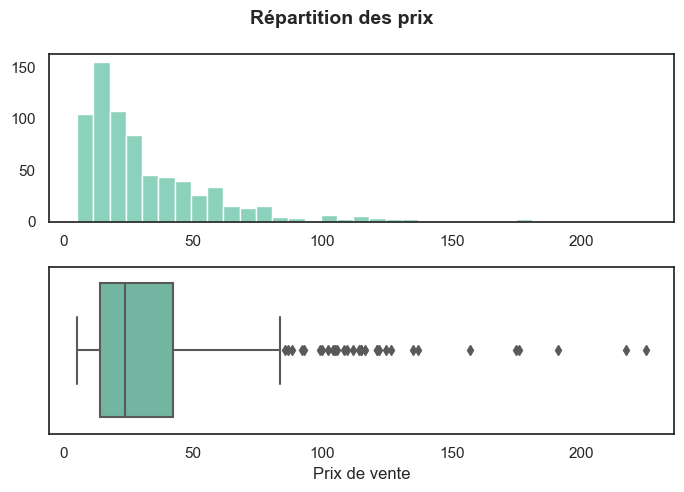

In [23]:
# On vérifie la plage de prix
plt.subplots(2, 12, sharex=True)
plt.suptitle("Répartition des prix", fontsize=14, fontweight='bold')

plt.subplot(212)
sns.boxplot(data=data, x='price')
plt.xlabel("Prix de vente")

plt.subplot(211)
sns.histplot(data=data, x='price')
plt.xlabel(None)
plt.ylabel(None)

plt.show()

In [24]:
# On constate que la distribution des prix est très dense en dessous de 50€ mais très étalée sur les prix plus élevés
# Ce que nous confirme un calcul du skewness

data['price'].skew()

2.58090126300337

#### Méthode z-score

In [25]:
# On calcul le z-score pour chaque produit
data['z_score'] = (data['price'] - data['price'].mean()) / data['price'].std()

# On affiche la liste des produits où le score est supérieur à 3
data.loc[abs(data['z_score']) > 3,
         ['product_id', 'post_title', 'price', 'stock_quantity', 'total_sales']].sort_values('price', ascending=False)

,product_id,post_title,price,stock_quantity,total_sales
291,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,0,5.0
525,5001,David Duband Charmes-Chambertin Grand Cru 2014,217.5,20,0.0
692,5892,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3,10,3.0
310,4402,Cognac Frapin VIP XO,176.0,8,13.0
657,5767,Camille Giroud Clos de Vougeot 2016,175.0,12,0.0
313,4406,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0,3,0.0
478,4904,Domaine Des Croix Corton Charlemagne Grand Cru...,137.0,13,5.0
752,6126,Champagne Gosset Célébris Vintage 2007,135.0,10,2.0
293,4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,2,11.0
615,5612,Domaine Weinbach Gewurztraminer Grand Cru Furs...,124.8,12,0.0


#### Méthode inter-quartile

In [26]:
# On remet les prix en ordre croissant
data_price = data['price'].sort_values()
# On calcul Q1
Q1 = np.percentile(data_price, 25)
# On calcul Q3
Q3 = np.percentile(data_price, 75)
# On calcul l'interquartile (Q3 - Q1)
iqr = Q3 - Q1
# On filtre le data pour garder les produits dont le prix est > Q3 + 2.5 * icr
data.loc[data['price'] > Q3 + (2.5 * iqr), ['product_id', 'post_title', 'price', 'stock_quantity', 'total_sales']].sort_values('price', ascending=False)

,product_id,post_title,price,stock_quantity,total_sales
291,4352,Champagne Egly-Ouriet Grand Cru Millésimé 2008,225.0,0,5.0
525,5001,David Duband Charmes-Chambertin Grand Cru 2014,217.5,20,0.0
692,5892,Coteaux Champenois Egly-Ouriet Ambonnay Rouge ...,191.3,10,3.0
310,4402,Cognac Frapin VIP XO,176.0,8,13.0
657,5767,Camille Giroud Clos de Vougeot 2016,175.0,12,0.0
313,4406,Cognac Frapin Château de Fontpinot 1989 20 Ans...,157.0,3,0.0
478,4904,Domaine Des Croix Corton Charlemagne Grand Cru...,137.0,13,5.0
752,6126,Champagne Gosset Célébris Vintage 2007,135.0,10,2.0
293,4355,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,126.5,2,11.0
615,5612,Domaine Weinbach Gewurztraminer Grand Cru Furs...,124.8,12,0.0


#### Complément

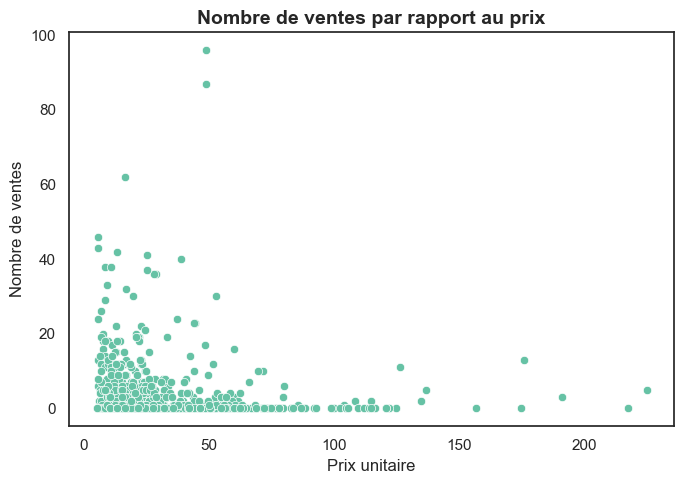

In [27]:
# Pour vérifier la cohérence des prix, on peux aussi vérifier la corrélation entre niveau de prix et niveau de ventes
plt.figure()
plt.title("Nombre de ventes par rapport au prix")
sns.scatterplot(data=data, x='price', y='total_sales')
plt.xlabel("Prix unitaire")
plt.ylabel("Nombre de ventes")
plt.show()

In [28]:
# On détecte 2 produits avec un niveau de vente élevé, on peut donc vérifier si le prix est cohérent
data.loc[data['total_sales'] > 80, ['product_id', 'post_title', 'stock_quantity', 'price', 'total_sales']]

,product_id,post_title,stock_quantity,price,total_sales
162,4144,Champagne Gosset Grand Rosé,11,49.0,87.0
286,4334,Champagne Gosset Grand Blanc de Blancs,0,49.0,96.0
